In [1]:
import numpy as np

from sklearn import preprocessing
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
import pickle
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import losses
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive');

In [3]:
# load patch wise Hela cell images/masks
DATA_PATH = "/content/drive/My Drive/"
infile = open(DATA_PATH+"Cell_Image_data_patch.p",'rb')
X_data = pickle.load(infile)

infile = open(DATA_PATH+"Cell_Image_label_patch.p",'rb')
y_label = pickle.load(infile)

In [4]:
# Dice metrics
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

# IoU as metrics
def IoU(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(y_true*y_pred)
    fn = K.sum(y_true*neg_y_pred)
    IoU = tp/(tp+fp+fn)
    return IoU

# Specificity as metrics
def Specificity(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(y_true*y_pred)
    fn = K.sum(y_true*neg_y_pred)
    Specificity = tn/(tn+fp)
    return Specificity
    
# Sensitivity as metrics
def Sensitivity(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(y_true*y_pred)
    fn = K.sum(y_true*neg_y_pred)
    Sensitivity = tp/(tp+fn)
    return Sensitivity

# Dice loss function
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [5]:
# using min-max scalar function for images/masks normalization 
def convertTo1D(X):
    new_X = []
    for image in X:
        im = image.flatten()
        new_X.append(im)
    return new_X

def convertTo2D(X):
    new_X = []
    for image in X:
        im = np.reshape(image,(256,256))
        new_X.append(im)
    return new_X

def minmaxscaler(X,y):
    scaler = MinMaxScaler((0,1))
    X_flat = convertTo1D(X_data)
    y_flat = convertTo1D(y_label)
    
    norm_X = scaler.fit_transform(X_flat)
    norm_y = scaler.fit_transform(y_flat)
    
    new_X = convertTo2D(norm_X)
    new_y = convertTo2D(norm_y)
    return new_X,new_y

In [6]:
# Creating the U-Net model and adding multiple layers in U-Net model

def apply_unet(pretrained_W = None, input_size = (256,256,1)):
    Inputs = Input(input_size)

    Conv1 = Conv2D(64,3, activation='relu',padding='same')(Inputs)
    Conv1 = Conv2D(64,3, activation='relu',padding='same')(Conv1)
    Pool1 = MaxPool2D(pool_size=(2,2))(Conv1)

    Conv2 = Conv2D(128,3, activation='relu',padding='same')(Pool1)
    Conv2 = Conv2D(128,3, activation='relu',padding='same')(Conv2)
    Pool2 = MaxPool2D(pool_size=(2,2))(Conv2)

    Conv3 = Conv2D(256,3, activation='relu',padding='same')(Pool2)
    Conv3 = Conv2D(256,3, activation='relu',padding='same')(Conv3)
    Pool3 = MaxPool2D(pool_size=(2,2))(Conv3)

    Conv4 = Conv2D(512,3, activation='relu',padding='same')(Pool3)
    Conv4 = Conv2D(512,3, activation='relu',padding='same')(Conv4)
    Pool4 = MaxPool2D(pool_size=(2,2))(Conv4)

    Conv5 = Conv2D(1024,3, activation='relu',padding='same')(Pool4)
    Conv5 = Conv2D(1024,3, activation='relu',padding='same')(Conv5)
    Up6 = UpSampling2D(size=(2,2))(Conv5)

    Conv6 = Conv2D(512,2, activation='relu',padding='same')(Up6)
    merge7 = concatenate([Conv4,Conv6], axis=3)

    Conv7 = Conv2D(512,2, activation='relu',padding='same')(merge7)
    Conv7 = Conv2D(512,2, activation='relu',padding='same')(Conv7)
    Up8 = UpSampling2D(size=(2,2))(Conv7)

    Conv8 = Conv2D(256,3, activation='relu', padding='same')(Up8)
    merge9 = concatenate([Conv3,Conv8], axis=3)

    Conv10 = Conv2D(256,3, activation='relu', padding='same')(merge9)
    Conv10 = Conv2D(256,3, activation='relu', padding='same')(Conv10)
    Up11 = UpSampling2D(size=(2,2))(Conv10)

    Conv12 = Conv2D(128,3, activation='relu', padding='same')(Up11)
    merge13 = concatenate([Conv2,Conv12], axis=3)

    Conv14 = Conv2D(128,3, activation='relu', padding='same')(merge13)
    Conv14 = Conv2D(128,3, activation='relu', padding='same')(Conv14)
    Up15 = UpSampling2D(size=(2,2))(Conv14)

    Conv16 = Conv2D(64,3, activation='relu', padding='same')(Up15)
    merge17 = concatenate([Conv1,Conv16], axis=3)

    Conv18 = Conv2D(64,3, activation='relu', padding='same')(merge17)
    Conv18 = Conv2D(64,3, activation='relu', padding='same')(Conv18)

    Conv19 = Conv2D(2,3,activation='relu', padding='same')(Conv18)
    Conv20 = Conv2D(1,1, activation='sigmoid')(Conv19)

    model = Model(input = Inputs, output = Conv20)

    model.compile(optimizer = Adam(1e-4), loss = [dice_loss], metrics= [dice_coef,IoU,Sensitivity,Specificity])


    model.summary()

    if pretrained_W :
        model.load_weights(pretrained_W)
    return model

In [7]:
# nornalize the images/masks
X_data,y_label = minmaxscaler(X_data,y_label)
X_data = np.asarray(X_data)
y_label = np.asarray(y_label)

In [8]:
# split the data into 90% training and 10% testing
x_train,x_test,y_train,y_test=train_test_split(X_data,y_label,test_size=0.1)

In [9]:
# create model for U-Net 
model1 = apply_unet()

# reshape the data and mask
train_images = x_train.reshape(-1,256,256,1)
train_label = y_train.reshape(-1,256,256,1)

# training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model1.fit(train_images,train_label, batch_size=4, epochs=10, verbose=1, validation_split=0.1, shuffle=True, callbacks=[model_checkpoint,es] )

# save the U-Net
model1.save('model1.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

Train on 2235 samples, validate on 249 samples
Epoch 1/10
2235/2235 [==============================] - 90s 40ms/step - loss: 0.1851 - dice_coef: 0.8149 - IoU: 0.7329 - Sensitivity: 0.8016 - Specificity: 0.9790 - val_loss: 0.1081 - val_dice_coef: 0.8926 - val_IoU: 0.8278 - val_Sensitivity: 0.8999 - val_Specificity: 0.9865

Epoch 00001: loss improved from inf to 0.18511, saving model to unet_membrane.hdf5
Epoch 2/10
2235/2235 [==============================] - 87s 39ms/step - loss: 0.1006 - dice_coef: 0.8994 - IoU: 0.8337 - Sensitivity: 0.8911 - Specificity: 0.9893 - val_loss: 0.1000 - val_dice_coef: 0.9006 - val_IoU: 0.8411 - val_Sensitivity: 0.9098 - val_Specificity: 0.9876

Epoch 00002: loss improved from 0.18511 to 0.10063, saving model to unet_membrane.hdf5
Epoch 3/10
2235/2235 [==============================] - 88s 39ms/step - loss: 0.0958 - dice_coef: 0.9042 - IoU: 0.8424 - Sensitivity: 0.8944 - Specificity: 0.9903 - val_loss: 0.0937 - val_dice_coef: 0.9069 - val_IoU: 0.8492 - val

In [10]:
# reshape the testing images/masks
test_images = x_test.reshape(-1,256,256,1)
test_label = y_test.reshape(-1,256,256)

In [11]:
# Dice score for prediction evaluation
def dice_score(pred, target):
    smooth = 1
    m1 = pred.flatten()  # Flatten
    m2 = target.flatten()  # Flatten
    intersection = (m1 * m2).sum()

    return (2 * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

# IOU score for prediction evaluation
def iou_score(pred, target):
    smooth = 1
    m1 = pred.flatten()  # Flatten
    m2 = target.flatten()  # Flatten
    intersection = (m1 * m2).sum()

    return (intersection + smooth) / (m1.sum() + m2.sum() + smooth - intersection)

# Sensitivity for prediction evaluation
def sensitivity_score(pred, target):
    m1 = pred.flatten()
    m2 = target.flatten()
    target_neg = 1 - target
    pred_neg = 1 - pred
    fp = (target_neg*pred).sum()
    tn = (target_neg*pred_neg).sum()
    tp = (pred*target).sum()
    fn = (target*pred_neg).sum()
    S = tp/(tp+fn)
    return S

# Specificity for prediction evaluation
def specificity_score(pred, target):
    m1 = pred.flatten()
    m2 = target.flatten()
    target_neg = 1 - target
    pred_neg = 1 - pred
    fp = (target_neg*pred).sum()
    tn = (target_neg*pred_neg).sum()
    tp = (pred*target).sum()
    fn = (target*pred_neg).sum()
    S = tn/(tn+fp)
    return S

In [12]:
# use model to predict the testing images
y_test_pred = model1.predict(test_images)

In [13]:
# reshape the predicted result
y_test_pred = y_test_pred.reshape(-1,256,256)

In [14]:
# calculate the metrics for testing images
def get_metrics(y_test_pred,test_label):
    val1 = 0
    val2 = 0
    val3 = 0
    val4 = 0
    for i in range(y_test_pred.shape[0]):
        val1 = val1 + dice_score(y_test_pred[i],test_label[i])
        val2 = val2 + iou_score(y_test_pred[i],test_label[i])
        val3 = val3 + sensitivity_score(y_test_pred[i],test_label[i])
        val4 = val4 + specificity_score(y_test_pred[i],test_label[i])

    dice_val = val1/y_test_pred.shape[0]
    iou_val = val2/y_test_pred.shape[0]
    sen_val = val3/y_test_pred.shape[0]
    spec_val = val4/y_test_pred.shape[0]

    print("dice score = ",round(dice_val,2))
    print("Iou score = ",round(iou_val,2))
    print("sensitivity score = ",round(sen_val,2))
    print("specificity score = ",round(spec_val,2))

In [15]:
# report the metrics for testing images
get_metrics(y_test_pred,test_label)

dice score =  0.91
Iou score =  0.84
sensitivity score =  0.95
specificity score =  0.98


In [16]:
# show the images as follows:
def print_results(n):
    for i in range(n):
        plt.imshow(x_test[i],cmap='gray')
        plt.title('original image')
        plt.show()
        plt.imshow(y_test[i],cmap='gray')
        plt.title('ground truth mask')
        plt.show()
        plt.imshow(y_test_pred[i],cmap='gray')
        plt.title('predicted mask')
        plt.show()
        plt.imshow(y_test[i],cmap='gray')
        plt.imshow(y_test_pred[i],cmap='jet',alpha=0.75)
        plt.title('overlay mask')
        plt.show()
        print('==========================================================')

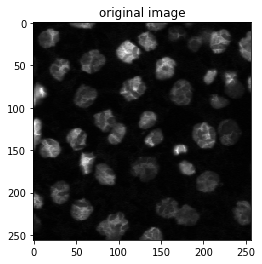

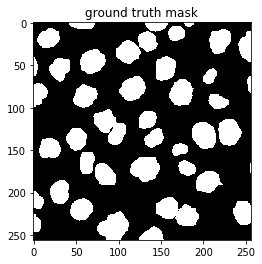

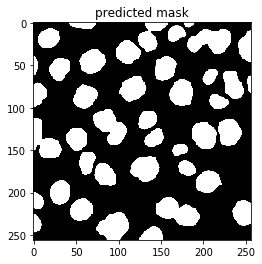

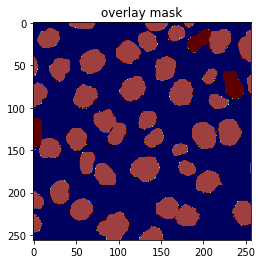

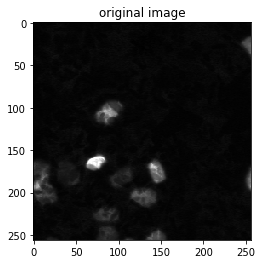

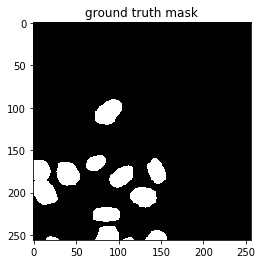

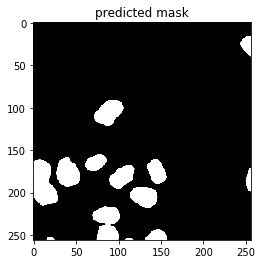

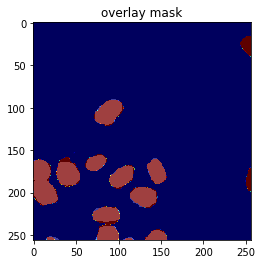

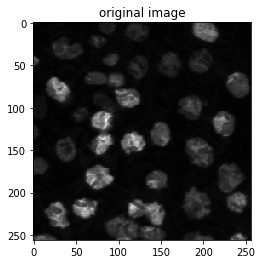

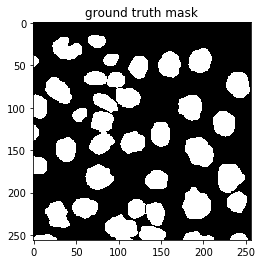

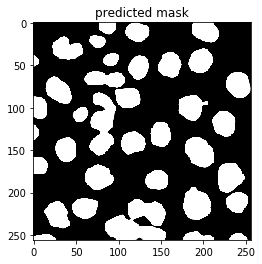

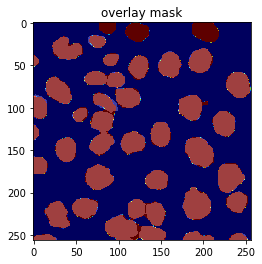

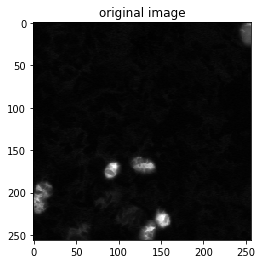

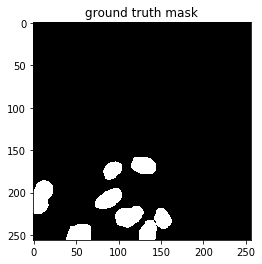

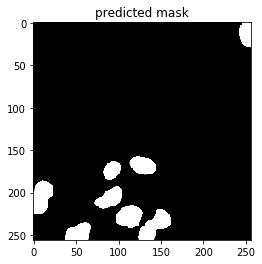

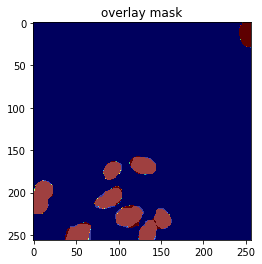

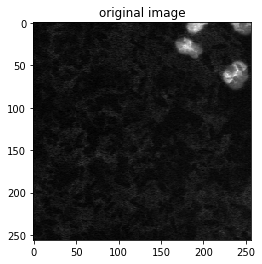

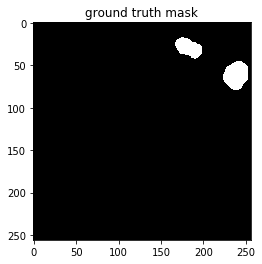

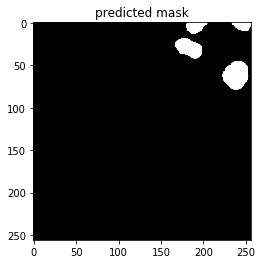

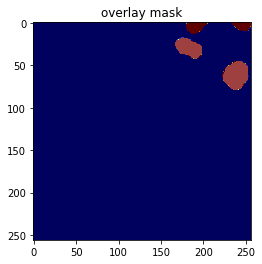

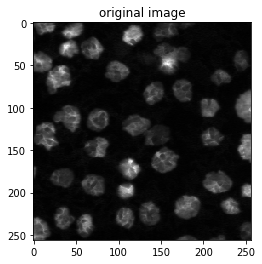

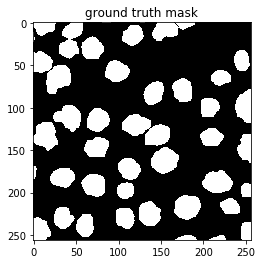

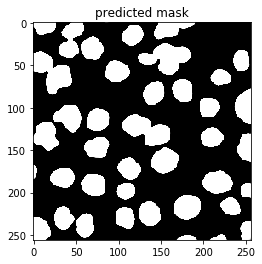

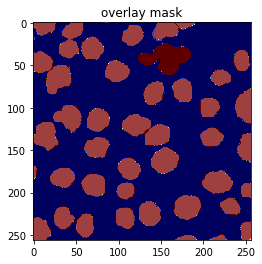

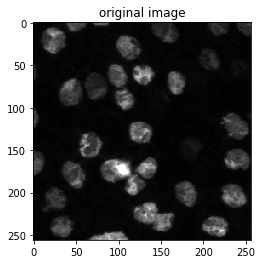

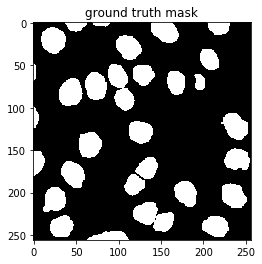

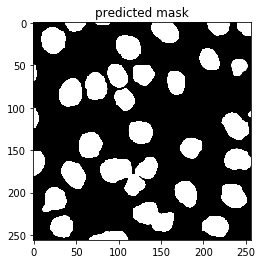

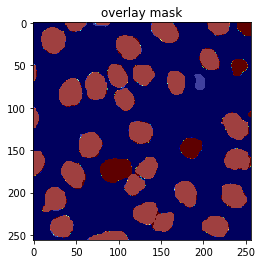

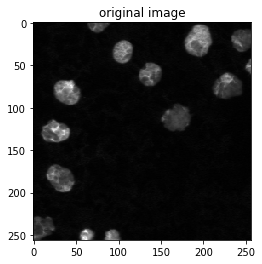

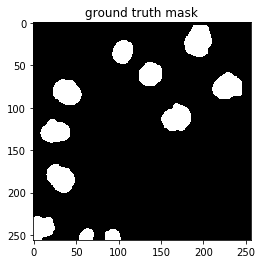

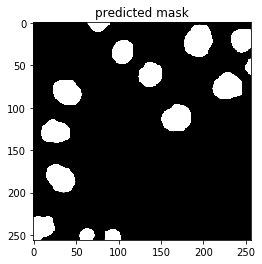

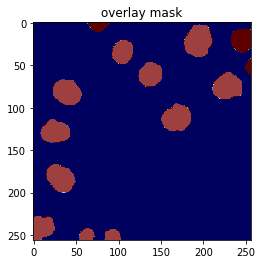

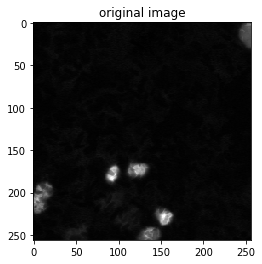

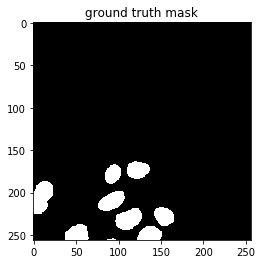

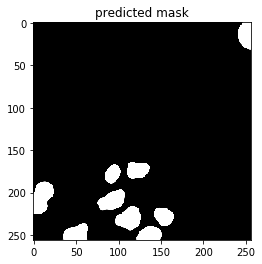

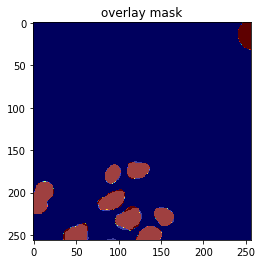

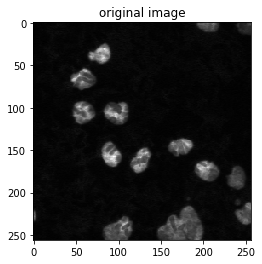

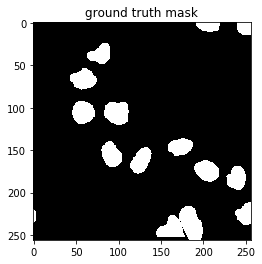

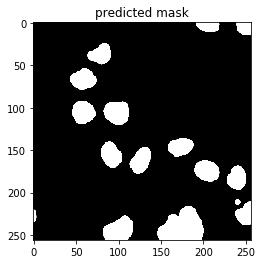

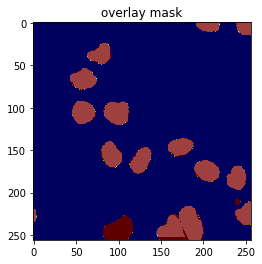

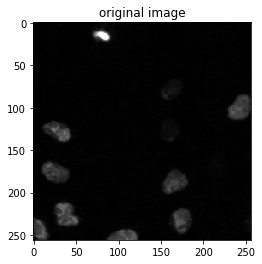

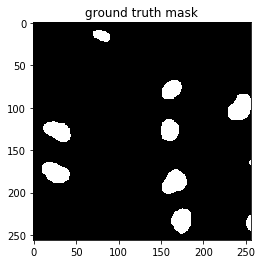

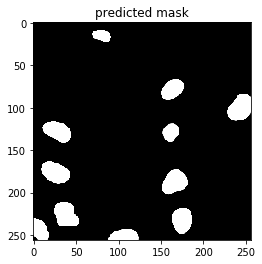

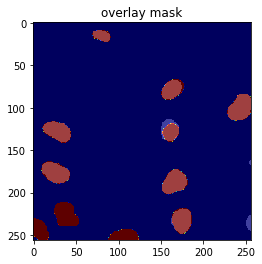

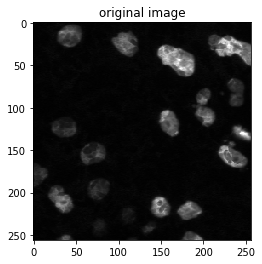

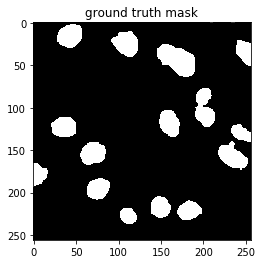

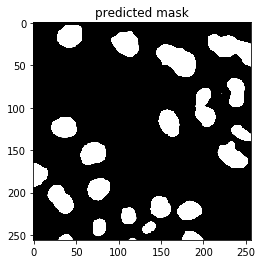

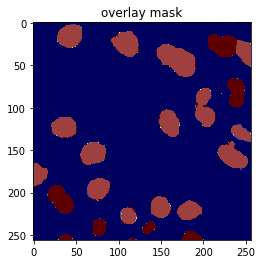

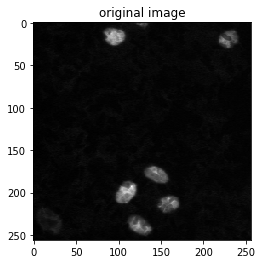

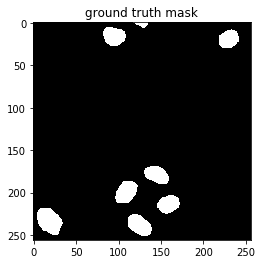

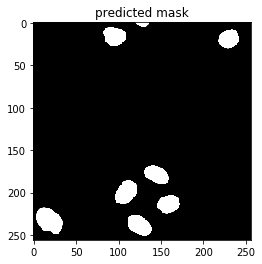

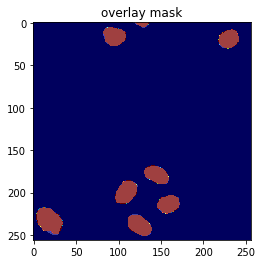

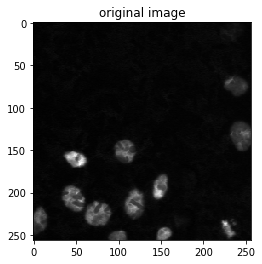

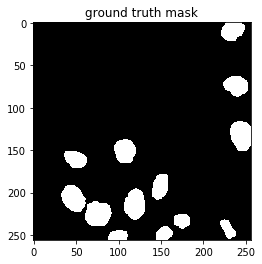

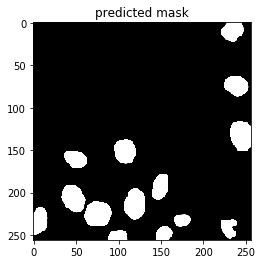

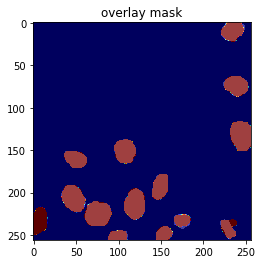

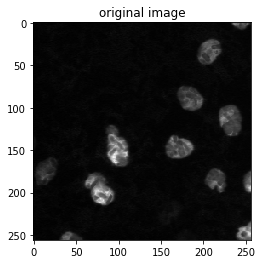

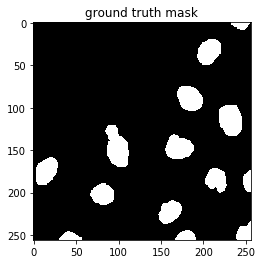

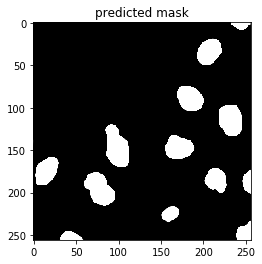

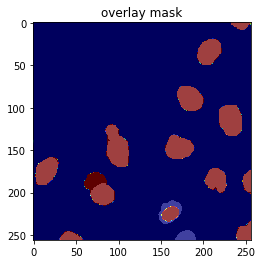

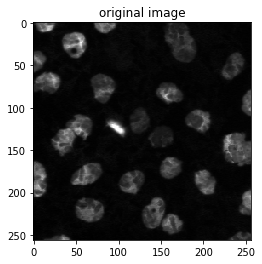

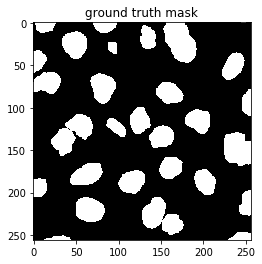

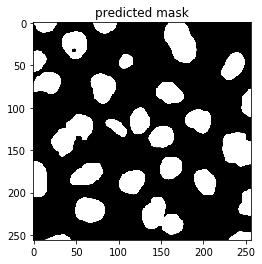

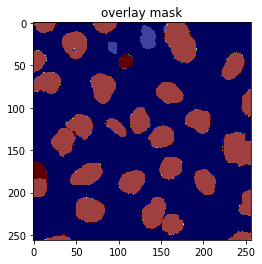

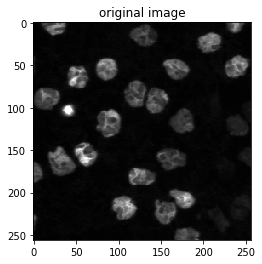

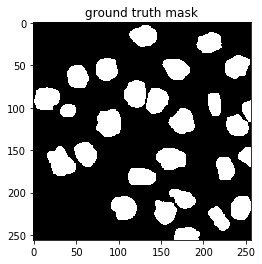

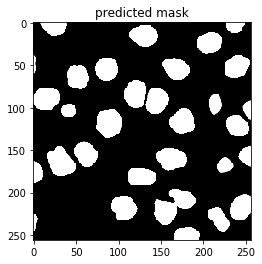

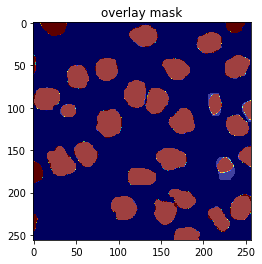

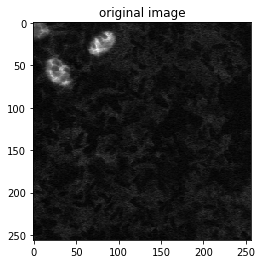

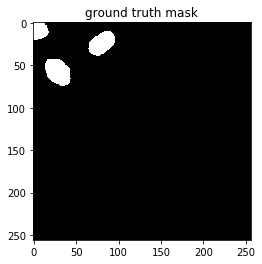

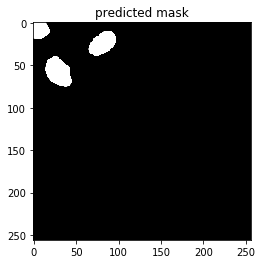

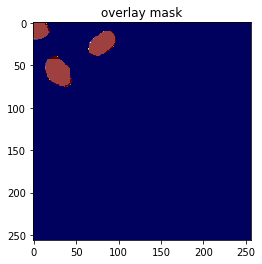

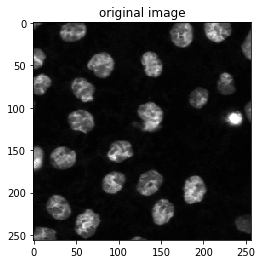

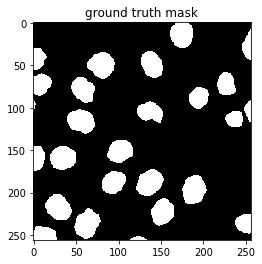

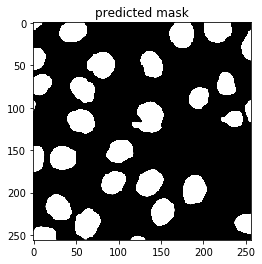

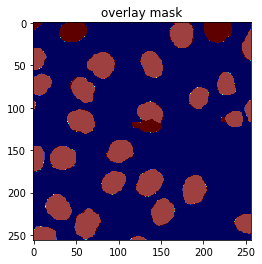

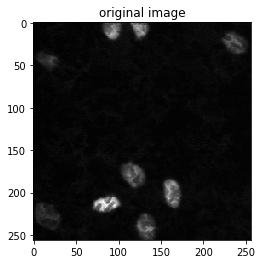

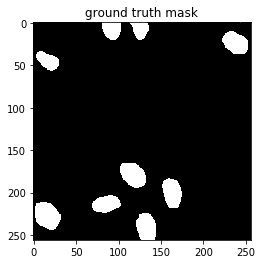

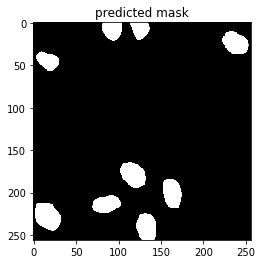

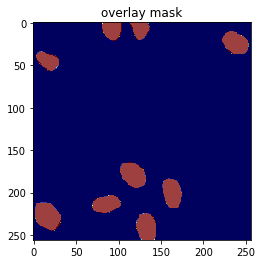

In [17]:
print_results(20)